# Bayesian Structural Time Series: Forecasting

This notebook shows how Bayesian Structural Time Series (BSTS) analysis can be used to forecast and decompose time series for enterprise needs. We focus on demand forecasting use case.

This tutorial is structured as follows:
* We use a public dataset that contains about 2 months of electricity demand and temperature (which is a regressor in this case) values with hourly resolution.
* We use Structural Time Series library from TensorFlow Probability for forecasting. The implementation is adoped from this [example](https://blog.tensorflow.org/2019/03/structural-time-series-modeling-in.html).  
* We decompose both the original series and the forecast into components (trend, seasonal, covariates, and autoregtressive).

In [7]:
import matplotlib as mpl
from matplotlib import pylab as plt
import matplotlib.dates as mdates
import seaborn as sns
import collections
import numpy as np
import pandas as pd

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
sns.set_context("notebook", font_scale=1.)
sns.set_style("whitegrid")

import tensorflow.compat.v2 as tf
import tensorflow_probability as tfp

from tensorflow_probability import distributions as tfd
from tensorflow_probability import sts

tf.enable_v2_behavior()

## Data Loading and Visualization

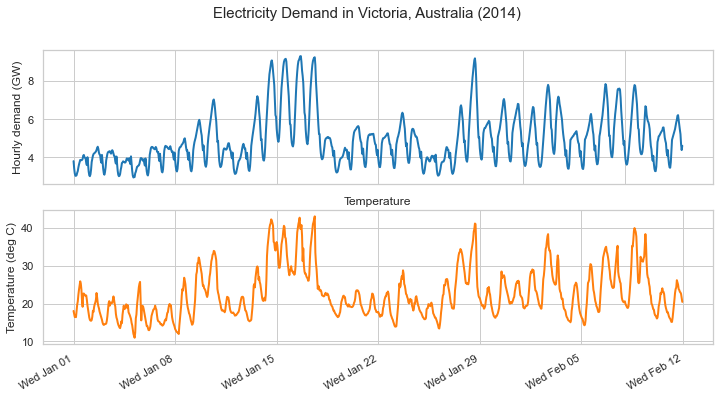

In [8]:
demand_dates = np.arange('2014-01-01', '2014-02-26', dtype='datetime64[h]')
demand_loc = mdates.WeekdayLocator(byweekday=mdates.WE)
demand_fmt = mdates.DateFormatter('%a %b %d')

data = pd.read_csv('../resources/time-series/electricity-demand-victoria.csv', comment='#', header=None).T
data = pd.concat([data, pd.DataFrame(demand_dates)], axis=1)
data.columns = ["demand", "temperature", "date"]

num_forecast_steps = 24 * 7 * 2 # two weeks
data_training = data[:-num_forecast_steps]
data_test = data[-num_forecast_steps:]

colors = sns.color_palette()
c1, c2 = colors[0], colors[1]

fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(2, 1, 1)
ax.plot(data_training.date,
        data_training.demand, lw=2, label="training data")
ax.set_ylabel("Hourly demand (GW)")

ax = fig.add_subplot(2, 1, 2)

ax.plot(data_training.date,
        data_training.temperature, lw=2, label="training data", c=c2)
ax.set_ylabel("Temperature (deg C)")
ax.set_title("Temperature")
ax.xaxis.set_major_locator(demand_loc)
ax.xaxis.set_major_formatter(demand_fmt)
fig.suptitle("Electricity Demand in Victoria, Australia (2014)", fontsize=15)
fig.autofmt_xdate()

In [16]:
len(data_training) #+ len(data_test)

1008

In [9]:
#
# Plotting functions
#
def plot_forecast(x, y,
                  forecast_mean, forecast_scale, forecast_samples,
                  title, x_locator=None, x_formatter=None):
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]
    fig = plt.figure(figsize=(12, 6))
    ax = fig.add_subplot(1, 1, 1)

    num_steps = len(y)
    num_steps_forecast = forecast_mean.shape[-1]
    num_steps_train = num_steps - num_steps_forecast

    ax.plot(x, y, lw=2, color=c1, label='ground truth')

    forecast_steps = np.arange(
        x[num_steps_train],
        x[num_steps_train]+num_steps_forecast,
        dtype=x.dtype)

    ax.plot(forecast_steps, forecast_samples.T, lw=1, color=c2, alpha=0.1)

    ax.plot(forecast_steps, forecast_mean, lw=2, ls='--', color=c2, label='forecast')
    ax.fill_between(forecast_steps,
                   forecast_mean-2*forecast_scale,
                   forecast_mean+2*forecast_scale, color=c2, alpha=0.2)

    ymin, ymax = min(np.min(forecast_samples), np.min(y)), max(np.max(forecast_samples), np.max(y))
    yrange = ymax-ymin
    ax.set_ylim([ymin - yrange*0.1, ymax + yrange*0.1])
    ax.set_title("{}".format(title))
    ax.legend()

    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
        fig.autofmt_xdate()

    return fig, ax

def plot_components(dates,
                    component_means_dict,
                    component_stddevs_dict,
                    x_locator=None,
                    x_formatter=None):
    colors = sns.color_palette()
    c1, c2 = colors[0], colors[1]

    axes_dict = collections.OrderedDict()
    num_components = len(component_means_dict)
    fig = plt.figure(figsize=(12, 2.5 * num_components))
    for i, component_name in enumerate(component_means_dict.keys()):
        component_mean = component_means_dict[component_name]
        component_stddev = component_stddevs_dict[component_name]

    ax = fig.add_subplot(num_components,1,1+i)
    ax.plot(dates, component_mean, lw=2)
    ax.fill_between(dates,
                     component_mean-2*component_stddev,
                     component_mean+2*component_stddev,
                     color=c2, alpha=0.5)
    ax.set_title(component_name)
    if x_locator is not None:
        ax.xaxis.set_major_locator(x_locator)
        ax.xaxis.set_major_formatter(x_formatter)
    axes_dict[component_name] = ax
    fig.autofmt_xdate()
    fig.tight_layout()
    return fig, axes_dict

## Model Specification and Fitting

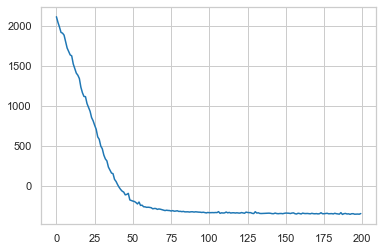

Inferred parameters:
observation_noise_scale: 0.0023976307372256976 +- 0.0027104231338718216
hour_of_day_effect/_drift_scale: 0.00647610716141428 +- 0.0010014404924998553
day_of_week_effect/_drift_scale: 0.01013060090204052 +- 0.012010927480606167
temperature_effect/_weights: [0.06335233] +- [0.00851327]
autoregressive/_coefficients: [0.98502825] +- [0.00609193]
autoregressive/_level_scale: 0.14436194813980885 +- 0.0025190166784586506


In [18]:
def build_model(observed_time_series, temperature):
    
    hour_of_day_effect = sts.Seasonal(
      num_seasons=24,
      observed_time_series=observed_time_series,
      name='hour_of_day_effect')

    day_of_week_effect = sts.Seasonal(
      num_seasons=7, num_steps_per_season=24,
      observed_time_series=observed_time_series,
      name='day_of_week_effect')
    
    temperature_effect = sts.LinearRegression(
      design_matrix=tf.reshape(temperature - np.mean(temperature), (-1, 1)), 
      name='temperature_effect')

    autoregressive = sts.Autoregressive(
      order=1,
      observed_time_series=observed_time_series,
      name='autoregressive')
    
    model = sts.Sum([hour_of_day_effect,
                     day_of_week_effect,
                     temperature_effect,
                     autoregressive],
                     observed_time_series=observed_time_series)
    return model

demand_model = build_model(data_training.demand, data.temperature)
variational_posteriors = tfp.sts.build_factored_surrogate_posterior(model=demand_model)


num_variational_steps = 200 
num_variational_steps = int(num_variational_steps)

optimizer = tf.optimizers.Adam(learning_rate=.1)
# Using fit_surrogate_posterior to build and optimize the variational loss function.
@tf.function(experimental_compile=True)
def train():
    elbo_loss_curve = tfp.vi.fit_surrogate_posterior(
        target_log_prob_fn=demand_model.joint_log_prob(observed_time_series=data_training.demand),
        surrogate_posterior=variational_posteriors,
        optimizer=optimizer,
        num_steps=num_variational_steps)
    return elbo_loss_curve

elbo_loss_curve = train()

plt.plot(elbo_loss_curve)
plt.show()

# Draw samples from the variational posterior.
q_samples_demand_ = variational_posteriors.sample(50)

print("Inferred parameters:")
for param in demand_model.parameters:
    print("{}: {} +- {}".format(param.name,
                                np.mean(q_samples_demand_[param.name], axis=0),
                                np.std(q_samples_demand_[param.name], axis=0)))

## Forecasting

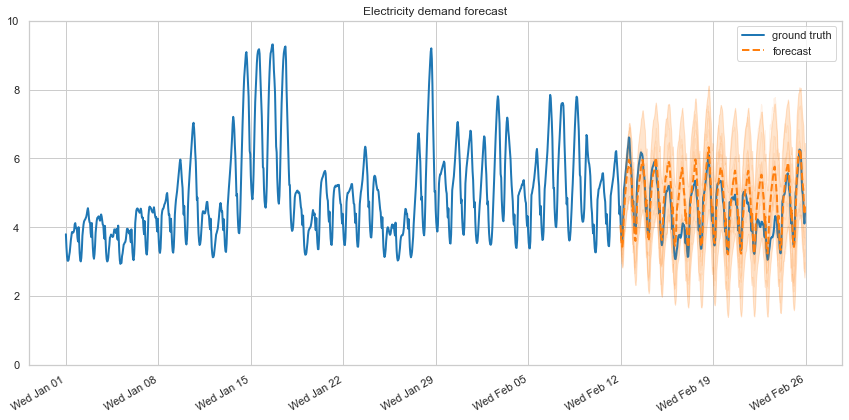

In [19]:
demand_forecast_dist = tfp.sts.forecast(
    model=demand_model,
    observed_time_series=data_training.demand,
    parameter_samples=q_samples_demand_,
    num_steps_forecast=num_forecast_steps)

num_samples=10

(
    demand_forecast_mean,
    demand_forecast_scale,
    demand_forecast_samples
) = (
    demand_forecast_dist.mean().numpy()[..., 0],
    demand_forecast_dist.stddev().numpy()[..., 0],
    demand_forecast_dist.sample(num_samples).numpy()[..., 0]
)

fig, ax = plot_forecast(demand_dates, data.demand,
                        demand_forecast_mean,
                        demand_forecast_scale,
                        demand_forecast_samples,
                        title="Electricity demand forecast",
                        x_locator=demand_loc, x_formatter=demand_fmt)
ax.set_ylim([0, 10])
fig.tight_layout()

## Decomposition

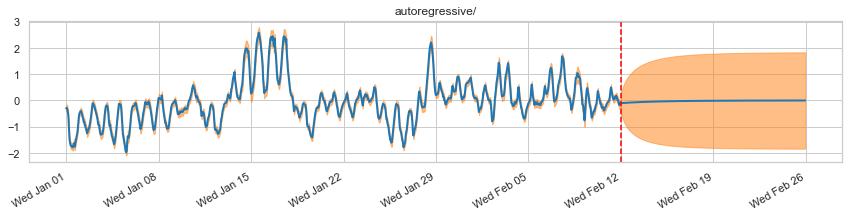

In [20]:

component_dists = sts.decompose_by_component(
    demand_model,
    observed_time_series=data_training.demand,
    parameter_samples=q_samples_demand_)

forecast_component_dists = sts.decompose_forecast_by_component(
    demand_model,
    forecast_dist=demand_forecast_dist,
    parameter_samples=q_samples_demand_)

demand_component_means_, demand_component_stddevs_ = (
    {k.name: c.mean() for k, c in component_dists.items()},
    {k.name: c.stddev() for k, c in component_dists.items()}
)

demand_forecast_component_means_, demand_forecast_component_stddevs_ = (
    {k.name: c.mean() for k, c in forecast_component_dists.items()},
    {k.name: c.stddev() for k, c in forecast_component_dists.items()}
)

# Concatenate the training data with forecasts for plotting.
component_with_forecast_means_ = collections.OrderedDict()
component_with_forecast_stddevs_ = collections.OrderedDict()
for k in demand_component_means_.keys():
    component_with_forecast_means_[k] = np.concatenate([
      demand_component_means_[k],
      demand_forecast_component_means_[k]], axis=-1)
    component_with_forecast_stddevs_[k] = np.concatenate([
      demand_component_stddevs_[k],
      demand_forecast_component_stddevs_[k]], axis=-1)

fig, axes = plot_components(
    demand_dates,
    component_with_forecast_means_,
    component_with_forecast_stddevs_,
    x_locator=demand_loc, x_formatter=demand_fmt)
for ax in axes.values():
    ax.axvline(demand_dates[-num_forecast_steps], linestyle="--", color='red')